In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Preprocessing training dataset

Download the dataset at http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/ -> EnglishFnt.tgz -> Take folders from Sample001 to Sample036 and copy them in a folder '0-9_and_A-Z' in the same directory of this notebook.

- resize from 128x128 to 32x32;
- label all images (they are collected in different folders, in order from 0 to 9 and then from A to Z);
- convert them into torch tensors.

In [2]:
# some fonts used are completely misleading, thus I checked them and we are going to filter them out manually

index = \
[i for i in range(161,165)] +\
[i for i in range(209,213)] +\
[i for i in range(293,297)] +\
[i for i in range(385,389)] +\
[i for i in range(401,403)] +\
[i for i in range(501,505)] +\
[i for i in range(529,533)] +\
[i for i in range(557,561)] +\
[i for i in range(613,617)] +\
[i for i in range(629,633)] +\
[i for i in range(689,693)] +\
[i for i in range(701,705)] +\
[i for i in range(753,761)] +\
[i for i in range(777,793)] +\
[i for i in range(805,809)] +\
[i for i in range(873,881)] +\
[i for i in range(941,945)] +\
[i for i in range(993,1001)]

index = np.array(index) - 1 #offset in the indexing

mask = np.ones(1016)
for i in index:
    mask[i] = 0
mask = mask.astype(bool)

In [3]:
import skimage
from os import walk

In [4]:
common_path = '0-9_and_A-Z/Sample'
images = []
labels = []

for n in range(1,37):
    f = []
    x = "%03.0f"%n
    mypath = '0-9_and_A-Z/Sample'+x
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    print("Number of files in "+mypath+" : ", len(f), '\n')
    
    for i in range(len(f)):
        f[i] = mypath+'/'+f[i]
        
    template_imgs = skimage.io.imread_collection(f) # loads all the images
    
    rescaled_template_imgs = []
    #skimage.io.imshow(template_imgs[0])
    
    for i in range(len(template_imgs)):
        image_rescaled = skimage.transform.rescale(template_imgs[i], 1.0 / 4.0, anti_aliasing=False) # preprocessing
        rescaled_template_imgs.append(image_rescaled)
        
    rescaled_template_imgs = np.array(rescaled_template_imgs)
    filtered_imgs = rescaled_template_imgs[mask]   
    hotEncodedLabel = np.array([i==n-1 for i in range(36)], dtype=int) # one hot encoding
    class_labels = np.full((len(filtered_imgs),len(hotEncodedLabel)), hotEncodedLabel)
    
    #skimage.io.imshow(rescaled_template_imgs[0])
    images.append(filtered_imgs)
    labels.append(class_labels)
    #print(template_imgs.shape)
    

Number of files in 0-9_and_A-Z/Sample001 :  1016 



/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Number of files in 0-9_and_A-Z/Sample002 :  1016 

Number of files in 0-9_and_A-Z/Sample003 :  1016 

Number of files in 0-9_and_A-Z/Sample004 :  1016 

Number of files in 0-9_and_A-Z/Sample005 :  1016 

Number of files in 0-9_and_A-Z/Sample006 :  1016 

Number of files in 0-9_and_A-Z/Sample007 :  1016 

Number of files in 0-9_and_A-Z/Sample008 :  1016 

Number of files in 0-9_and_A-Z/Sample009 :  1016 

Number of files in 0-9_and_A-Z/Sample010 :  1016 

Number of files in 0-9_and_A-Z/Sample011 :  1016 

Number of files in 0-9_and_A-Z/Sample012 :  1016 

Number of files in 0-9_and_A-Z/Sample013 :  1016 

Number of files in 0-9_and_A-Z/Sample014 :  1016 

Number of files in 0-9_and_A-Z/Sample015 :  1016 

Number of files in 0-9_and_A-Z/Sample016 :  1016 

Number of files in 0-9_and_A-Z/Sample017 :  1016 

Number of files in 0-9_and_A-Z/Sample018 :  1016 

Number of files in 0-9_and_A-Z/Sample019 :  1016 

Number of files in 0-9_and_A-Z/Sample020 :  1016 

Number of files in 0-9_and_A-Z/

In [5]:
images = np.array(images).reshape((-1,1,32,32)) 
labels = np.array(labels).reshape((-1,36))

In [6]:
images.shape #(n_samples,n_channels,width,height)

(33192, 1, 32, 32)

In [7]:
labels.shape #(n_samples,n_classes)

(33192, 36)

In [8]:
import string

capital_letters = list(string.ascii_uppercase)
numbers = list(['%d'%i for i in range(10)])
num_and_letters = numbers+capital_letters # list of all the numbers and characters to recognize

numbers_and_chars_dict = {}
for i in range(36):
    numbers_and_chars_dict[i] = num_and_letters[i]

In [9]:
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

In [10]:
from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler
# used to manage split in training, validation and test set and also to sample batches

tensDataset = TensorDataset(images,labels)

train_size = int(0.8 * len(tensDataset)) # 80% for training and validation
test_size = len(tensDataset) - train_size # 20% for test
train_set, test_set = torch.utils.data.random_split(tensDataset, [train_size, test_size])

In [11]:
print("Train + validation samples: ", train_size)

Train + validation samples:  26553


In [12]:
#Training
n_training_samples = int(0.8*train_size) #again take 80% of the training+validation for training
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
train_loader = DataLoader(train_set, batch_size=16,sampler=train_sampler, num_workers=2)

#Validation
n_val_samples = train_size - n_training_samples # and 20% for validation
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
val_loader = DataLoader(train_set, batch_size=128, sampler=val_sampler, num_workers=2)

#Test
n_test_samples = test_size
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)

In [1]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 3, stride = 1, padding = 1 )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 12, kernel_size = 3, stride = 1, padding = 1 )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(12 * 8 * 8, 256)  # 8*8 from image dimension
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 36)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
                   
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
                   
        x = x.view(-1, self.num_flat_features(x))
                   
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [2]:
CNN = Net()
print(CNN)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
)


In [29]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [30]:
import time

def trainNet(net, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", 16)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            #print(labels)
            #break
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, torch.max(labels, 1)[1])
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for inputs, labels in val_loader:
            
            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, torch.max(labels, 1)[1])
            total_val_loss += val_loss_size.data.item()
            
        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [31]:
CNN = CNN.double()
trainNet(CNN, n_epochs=15, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 16
epochs= 15
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.87 took: 6.19s
Epoch 1, 20% 	 train_loss: 1.14 took: 6.14s
Epoch 1, 30% 	 train_loss: 0.79 took: 6.24s
Epoch 1, 40% 	 train_loss: 0.66 took: 5.88s
Epoch 1, 50% 	 train_loss: 0.56 took: 6.28s
Epoch 1, 60% 	 train_loss: 0.53 took: 6.32s
Epoch 1, 70% 	 train_loss: 0.46 took: 5.96s
Epoch 1, 80% 	 train_loss: 0.41 took: 6.04s
Epoch 1, 90% 	 train_loss: 0.43 took: 5.95s
Validation loss = 0.36
Epoch 2, 10% 	 train_loss: 0.35 took: 6.70s
Epoch 2, 20% 	 train_loss: 0.38 took: 6.42s
Epoch 2, 30% 	 train_loss: 0.32 took: 6.37s
Epoch 2, 40% 	 train_loss: 0.32 took: 6.51s
Epoch 2, 50% 	 train_loss: 0.29 took: 6.62s
Epoch 2, 60% 	 train_loss: 0.29 took: 6.85s
Epoch 2, 70% 	 train_loss: 0.28 took: 6.63s
Epoch 2, 80% 	 train_loss: 0.29 took: 6.50s
Epoch 2, 90% 	 train_loss: 0.28 took: 6.60s
Validation loss = 0.27
Epoch 3, 10% 	 train_loss: 0.20 took: 6.63s
Epoch 3, 20% 	 train_loss: 0.24 took: 7.07s

B


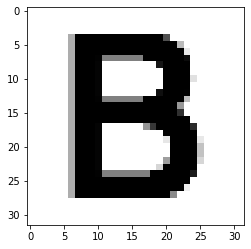

F


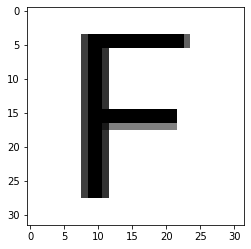

H


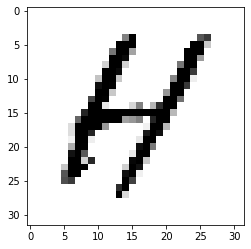

Y


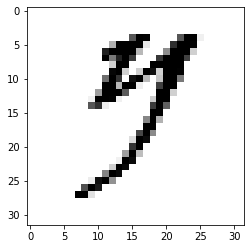

In [32]:
with torch.no_grad():
    dataiter = iter(test_loader)
    inputs, labels = dataiter.next()
    outputs = CNN(inputs)
    _, outputs = torch.max(outputs.data, 1)
    scalar_label = outputs.numpy()
    for i in range(4):
        print(numbers_and_chars_dict[scalar_label[i]])
        plt.imshow(inputs[i,0], cmap='gray')
        plt.show()

In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.numpy()
        scalar_labels = np.dot(labels,np.arange(0,36))
        total += len(scalar_labels)
        correct += (predicted == scalar_labels).sum()

print('Accuracy of the network on the %d test images: %d %%' % (test_size,
    100 * correct / total))


Accuracy of the network on the 6639 test images: 95 %


Z


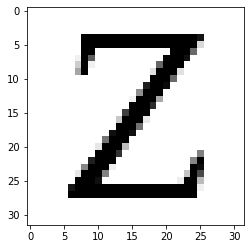

In [40]:
# and to get the prediction for a single image
input_img = images[0].reshape((-1,)+images[0].shape)
#label = labels[0]
outputs = CNN(input_img)
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.numpy()
char = numbers_and_chars_dict[predicted[0]]
print(char)
plt.imshow(input_img[0,0], cmap='gray')
plt.show()

In [41]:
# Save model
torch.save(CNN.state_dict(), 'saved_model.pth')

#Load model (works only if the model's structures are the same)
state_dict = torch.load('saved_model.pth')
CNN1 = Net().double() # new net still works!
CNN1.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Z


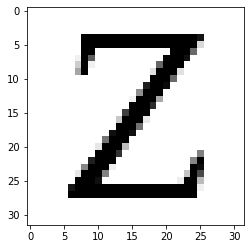

In [42]:
# and to get the prediction for a single image
input_img = images[0].reshape((-1,)+images[0].shape)
#label = labels[0]
outputs = CNN1(input_img)
_, predicted = torch.max(outputs.data, 1)
predicted = predicted.numpy()
char = numbers_and_chars_dict[predicted[0]]
print(char)
plt.imshow(input_img[0,0], cmap='gray')
plt.show()